# Importando bibliotecas


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib


# Base de dados



Foi utilizado um conjunto de dados do site kaggle da empresa Amazon Reviews Multi que é uma empresa multinacional de tecnologia e comércio eletrônico. Segue o link do dataset https://www.kaggle.com/datasets/mexwell/amazon-reviews-multi?select=test.csv.

## Lendo arquivo csv

In [ ]:
nome_arquivo = 'test.csv'
df = pd.read_csv(nome_arquivo)
df.head(10)


,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,de_0784695,product_de_0572654,reviewer_de_0645436,1,"Leider, leider nach einmal waschen ausgebliche...",Leider nicht zu empfehlen,de,home
1,1,de_0759207,product_de_0567331,reviewer_de_0183703,1,zunächst macht der Anker Halter einen soliden ...,Gummierung nach 6 Monaten kaputt,de,wireless
2,2,de_0711785,product_de_0482105,reviewer_de_0182152,1,Siegel sowie Verpackung war beschädigt und war...,Flohmarkt ware,de,industrial_supplies
3,3,de_0964430,product_de_0616480,reviewer_de_0991563,1,Habe dieses Produkt NIE erhalten und das Geld ...,Katastrophe,de,industrial_supplies
4,4,de_0474538,product_de_0228702,reviewer_de_0316188,1,Die Träger sind schnell abgerissen,Reißverschluss klemmt,de,luggage
5,5,de_0178529,product_de_0846887,reviewer_de_0173544,1,Druckbild ist leider nicht akzeptabel. Die kom...,Keine Option,de,office_product
6,6,de_0217495,product_de_0056799,reviewer_de_0691450,1,🤬🤬🤬 Stoff löst sich nach kurzer Zeit,Kratzbaum,de,pet_products
7,7,de_0351383,product_de_0372132,reviewer_de_0100867,1,Beim zweiten Gebrauch bereits undicht!!!,Beim zweiten Gebrauch undicht!!!,de,kitchen
8,8,de_0647893,product_de_0302423,reviewer_de_0247487,1,Die Lieferung war prompt. 2 Gläser sind bereit...,Undicht,de,home
9,9,de_0292970,product_de_0278398,reviewer_de_0388260,1,Bin überhaupt nicht zufrieden. Das Handy ist m...,Panzerfolie,de,wireless


In [ ]:
df["language"].value_counts()



,count
language,
de,5000
en,5000
es,5000
fr,5000
ja,5000
zh,5000


Iremos deixar apenas os dados de inglês para esse modelo

In [ ]:
df = df[df['language'] == 'en']
df = df.reset_index(drop=True)

print(f"Quantidade de reviews em inglês: {len(df)}")
df.head()


Quantidade de reviews em inglês: 5000


,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,5000,en_0199937,product_en_0902516,reviewer_en_0097389,1,"These are AWFUL. They are see through, the fab...",Don’t waste your time!,en,apparel
1,5001,en_0863335,product_en_0348072,reviewer_en_0601537,1,I bought 4 and NONE of them worked. Yes I used...,One Star,en,other
2,5002,en_0565010,product_en_0356154,reviewer_en_0970351,1,On first use it didn't heat up and now it does...,Totally useless,en,other
3,5003,en_0963290,product_en_0583322,reviewer_en_0216125,1,You want an HONEST answer? I just returned fro...,Gold filled earrings,en,jewelry
4,5004,en_0238156,product_en_0487636,reviewer_en_0514203,1,The glue works fine but the container is impos...,Poor container,en,industrial_supplies


## Exploração e Limpeza de Dados (EDA)

## Explorando o dataset

Verificar quantidade de linhas, colunas e tipos de dados.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        5000 non-null   int64 
 1   review_id         5000 non-null   object
 2   product_id        5000 non-null   object
 3   reviewer_id       5000 non-null   object
 4   stars             5000 non-null   int64 
 5   review_body       5000 non-null   object
 6   review_title      4999 non-null   object
 7   language          5000 non-null   object
 8   product_category  5000 non-null   object
dtypes: int64(2), object(7)
memory usage: 351.7+ KB


Ver o tamanho do dataset:

In [ ]:
df.shape

(5000, 9)

Identificar colunas relevantes

In [ ]:
df.columns

Index(['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars',
       'review_body', 'review_title', 'language', 'product_category'],
      dtype='object')

## Limpeza  de dados

Verficando quantidade de dados nulos

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
review_id,0
product_id,0
reviewer_id,0
stars,0
review_body,0
review_title,1
language,0
product_category,0


Verificando quantidade de dados duplicados

In [ ]:
df.duplicated().sum()


np.int64(0)

In [ ]:
df.head()

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,5000,en_0199937,product_en_0902516,reviewer_en_0097389,1,"These are AWFUL. They are see through, the fab...",Don’t waste your time!,en,apparel
1,5001,en_0863335,product_en_0348072,reviewer_en_0601537,1,I bought 4 and NONE of them worked. Yes I used...,One Star,en,other
2,5002,en_0565010,product_en_0356154,reviewer_en_0970351,1,On first use it didn't heat up and now it does...,Totally useless,en,other
3,5003,en_0963290,product_en_0583322,reviewer_en_0216125,1,You want an HONEST answer? I just returned fro...,Gold filled earrings,en,jewelry
4,5004,en_0238156,product_en_0487636,reviewer_en_0514203,1,The glue works fine but the container is impos...,Poor container,en,industrial_supplies


### Rotulagem (regras de negócio)

No dataframe as colunas  alvos de acordo com a proposta dodesafio Hackathon seriam as colunas de comentários e o sentimento do cliente que  o avaliou, com esse objetivo as colunas usadas para o desafio serão:

*   review_score
*   review_comment_message


In [ ]:
df_limpo = df.dropna(subset=['review_body']).copy()

df_limpo = df_limpo[['review_body', 'stars']]
df_limpo.head()

,review_body,stars
0,"These are AWFUL. They are see through, the fab...",1
1,I bought 4 and NONE of them worked. Yes I used...,1
2,On first use it didn't heat up and now it does...,1
3,You want an HONEST answer? I just returned fro...,1
4,The glue works fine but the container is impos...,1


In [ ]:
df_limpo['stars'].value_counts()

,count
stars,
1,1000
2,1000
3,1000
4,1000
5,1000


A coluna de 'review_text' será o comentário/avaliação escrita, já a coluna de 'overall_rating' terá a função de indicar qual o tipo/emoção da avaliação, como a coluna 'overall_rating' é do tipo int64 e precisamos classificar as avaliações de modo binário (positivo ou negativo), aplicamos uma regra de negócios pra transformar as nota em sentimentos binários:


* Notas 1 e 2 = Negativo
* Nota 3 = removida do dataset
* Notas 4 e 5 = Positivo

Ao testar o modelo trinário(positivo, neutro ou negativo) e considerar a nota 3 como neutro, foi observado que o modelo não aprendeu o sentimento neutro pois os comentário eram ammbíguos como por exemplo: "Material bom, mas modelagem ruim!"ou "Veio a cor errada, mas serviu", pegando palavras que estão no TF-IDF tanto do negativo ("ruim"), quanto do positivo ("bom"). Então para uma máxima precisão usaremos uma classificação binária(positivo e negativo).


In [ ]:
df_limpo = df_limpo[df_limpo['stars'] != 3].copy()
def definir_sentimento_binario(score):
    return 'Positivo' if score > 3 else 'Negativo'

df_limpo['sentiment'] = df_limpo['stars'].apply(definir_sentimento_binario)
df_limpo.head()

,review_body,stars,sentiment
0,"These are AWFUL. They are see through, the fab...",1,Negativo
1,I bought 4 and NONE of them worked. Yes I used...,1,Negativo
2,On first use it didn't heat up and now it does...,1,Negativo
3,You want an HONEST answer? I just returned fro...,1,Negativo
4,The glue works fine but the container is impos...,1,Negativo


In [ ]:
#removendo a coluna de notas numéricas
df_limpo.drop(columns=['stars'], inplace=True)
df_limpo.head()

,review_body,sentiment
0,"These are AWFUL. They are see through, the fab...",Negativo
1,I bought 4 and NONE of them worked. Yes I used...,Negativo
2,On first use it didn't heat up and now it does...,Negativo
3,You want an HONEST answer? I just returned fro...,Negativo
4,The glue works fine but the container is impos...,Negativo


In [ ]:
df_limpo['sentiment'].value_counts()

,count
sentiment,
Negativo,2000
Positivo,2000


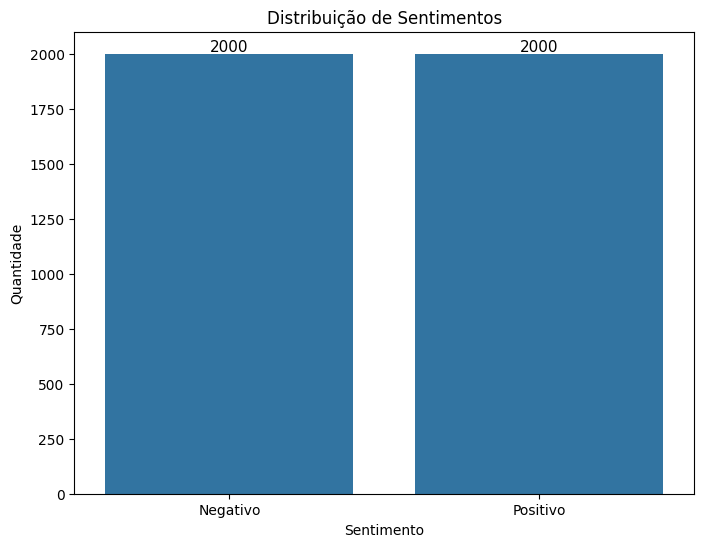

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_limpo, x='sentiment')
plt.title('Distribuição de Sentimentos')
plt.xlabel('Sentimento')
plt.ylabel('Quantidade')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

**De acordo com a contagem de linhas por sentiment é notável o equílibrio entre classes**



In [ ]:
df_limpo['review_length'] = df_limpo['review_body'].apply(len)
media_tamanho_comentarios = df_limpo['review_length'].mean()
print(f"Média do tamanho dos comentários: {media_tamanho_comentarios:.2f} caracteres")

Média do tamanho dos comentários: 173.98 caracteres


A média de caracteres da coluna 'review text' é de comentários médios

# DIVISÃO TREINO E TESTE

In [ ]:
X = df_limpo['review_body']
y = df_limpo['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
print(f"\nTamanho Treino: {len(X_train)}")
print(f"Tamanho Teste: {len(X_test)}")


Tamanho Treino: 3200
Tamanho Teste: 800


## Pipeline de Vetorização e Classificação

Nesta etapa, utilizamos um Pipeline para unificar a vetorização e o treinamento. A técnica TF-IDF transforma os textos crus em vetores numéricos, destacando termos distintos e filtrando palavras genéricas. Ao integrar esse processo diretamente ao modelo, garantimos que o algoritmo aprenda os padrões de sentimento (Positivo/Negativo) de forma eficiente e sem vazamento de dados (data leakage) entre treino e teste.



In [ ]:
nltk.download('stopwords')
es_stopwords = stopwords.words('spanish')

palavras_para_manter = ['no', 'ni', 'jamás', 'nada', 'nunca', 'tampoco']
stop_words_custom = [w for w in es_stopwords if w not in palavras_para_manter]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        min_df=3,
        max_features=5000,
        ngram_range=(1, 2),
        stop_words=stop_words_custom
    )),
    ('model', LogisticRegression(
        max_iter=1000,
        multi_class="auto",
        class_weight="balanced"

    ))
])

## Treinar o modelo supervisionado usando Regressão Logística

In [ ]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, min_df=3,
                                 ngram_range=(1, 2),
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'una',
                                             'su', 'al', 'lo', 'como', 'más',
                                             'pero', 'sus', 'le', 'ya', 'o',
                                             'este', 'sí', 'porque', 'esta', ...])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    multi_class='auto'))])

previsõess

In [ ]:
y_pred = pipeline.predict(X_test)

# Critérios de Avaliação do Modelo

## Calcular Acurácia
visão geral do desempenho

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")


Acurácia: 0.83


## Calcular precisão
indica quantos positivos previstos estavam corretos

In [ ]:
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precisão: {precision:.2f}")


Precisão: 0.83


## Calcular recall
mostra se o modelo está perdendo exemplos importantes

In [ ]:
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.2f}")


Recall: 0.83


## Calcular F1-Score
equilíbrio entre precisão e recall

In [ ]:
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score: {f1:.2f}")


F1-Score: 0.83


In [ ]:
y_pred = pipeline.predict(X_test)

print(classification_report(
    y_test,
    y_pred,
    target_names=["negativo", "positivo"]
))


              precision    recall  f1-score   support

    negativo       0.84      0.81      0.82       400
    positivo       0.82      0.84      0.83       400

    accuracy                           0.83       800
   macro avg       0.83      0.83      0.83       800
weighted avg       0.83      0.83      0.83       800



## Fazer e avaliar a matriz de confusão
identifica quais sentimentos estão sendo confundidos e quais o modelo está acertando,

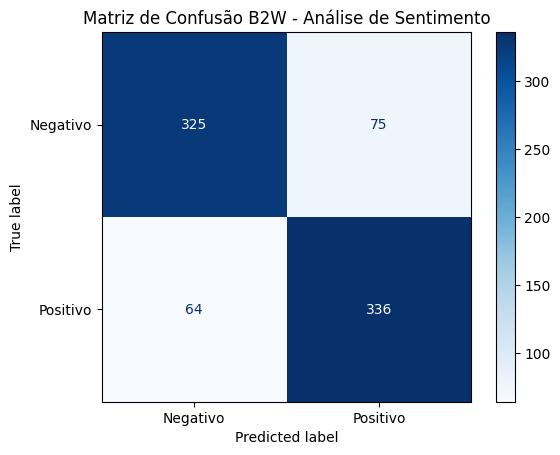

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=pipeline.classes_
)

disp.plot(cmap='Blues')
plt.title("Matriz de Confusão B2W - Análise de Sentimento")
plt.show()

# Conclusão do Modelo

### 1. Diagnóstico Geral
A Matriz de Confusão acima revela como o modelo (Regressão Logística + TF-IDF) se comportou ao classificar os dados de teste. Observamos uma **polarização forte**, onde o modelo performa muito bem nas extremidades (Positivo/Negativo), mas enfrenta dificuldades severas na classe intermediária.

### 2. Pontos Fortes (O que funcionou)
* **Alta Detecção de Positivos:** O modelo acertou **14.735** avaliações positivas (canto inferior direito). A taxa de erro aqui é muito baixa, indicando que quando o cliente elogia, o modelo entende com clareza.
* **Boa Detecção de Negativos:** Foram **6.210** acertos na classe Negativa. O modelo consegue capturar bem o vocabulário de insatisfação (ex: "não", "defeito", "ruim").

### 3. Conclusão
Com base nesta análise, conclui-se que ambas as classes se saíram bem nos acertos e métricas, aa que se destacou com mehor perfomance foi a classe positiva (a quantidade de comentários positivos ser maior influênciou no aprendizado do modelo também).

## Salvar o pipeline e o modelo com joblib.dump.

In [ ]:
joblib.dump(pipeline, 'sentiment_en.joblib')
pipeline_loaded = joblib.load('sentiment_en.joblib')

testando manualmente o modelo

In [ ]:
texto_teste = ["O atendimento foi rápido e excelente"]

predicao = pipeline_loaded.predict(texto_teste)
probabilidade = pipeline_loaded.predict_proba(texto_teste)

print("Previsão:", predicao[0])
print("Probabilidade:", max(probabilidade[0]))


Previsão: Negativo
Probabilidade: 0.5046428448526052


In [ ]:
def listar_top_palavras(df_fonte, sentimento_alvo, n=10):

    subset = df_fonte[df_fonte['sentiment'] == sentimento_alvo]['review_body']

    if len(subset) == 0:
        print(f"\n⚠️ Sem dados para o sentimento: {sentimento_alvo}")
        return

    tfidf = TfidfVectorizer(stop_words=stop_words_custom, max_features=5000, max_df=0.95)

    try:
        X = tfidf.fit_transform(subset.astype(str))

        soma_scores = X.sum(axis=0)

        palavras_scores = []
        for palavra, idx in tfidf.vocabulary_.items():
            palavras_scores.append((palavra, soma_scores[0, idx]))

        palavras_scores = sorted(palavras_scores, key=lambda x: x[1], reverse=True)

        print(f"\n=== TOP {n} PALAVRAS: {sentimento_alvo.upper()} ===")
        for i, (palavra, score) in enumerate(palavras_scores[:n]):
            print(f"{i+1}. {palavra} (Score: {score:.2f})")

    except ValueError as e:
        print(f"Erro ao processar {sentimento_alvo}: {e}")

sentimentos_existentes = df_limpo['sentiment'].unique()
print(f"Sentimentos encontrados no DF: {sentimentos_existentes}")

for s in sentimentos_existentes:
    if pd.notna(s):
        listar_top_palavras(df_limpo, s)

Sentimentos encontrados no DF: ['Negativo' 'Positivo']

=== TOP 10 PALAVRAS: NEGATIVO ===
1. the (Score: 163.67)
2. it (Score: 129.33)
3. and (Score: 98.50)
4. to (Score: 96.15)
5. not (Score: 87.25)
6. of (Score: 68.89)
7. this (Score: 67.82)
8. was (Score: 63.66)
9. is (Score: 62.84)
10. for (Score: 60.81)

=== TOP 10 PALAVRAS: POSITIVO ===
1. the (Score: 146.44)
2. it (Score: 124.01)
3. and (Score: 106.56)
4. to (Score: 98.88)
5. for (Score: 77.68)
6. is (Score: 73.90)
7. my (Score: 69.35)
8. this (Score: 67.95)
9. great (Score: 62.70)
10. but (Score: 57.85)


In [ ]:
# Função para extrair as top palavras do tf-idf (Mantida igual)
def get_top_tfidf_keywords_for_comment(comment, tfidf_vectorizer_component, n=5):
    tfidf_matrix = tfidf_vectorizer_component.transform([comment])

    if tfidf_matrix.nnz == 0:
        return []

    feature_names = tfidf_vectorizer_component.get_feature_names_out()

    scores = {}
    for col_idx, score_value in zip(tfidf_matrix.indices, tfidf_matrix.data):
        scores[feature_names[col_idx]] = score_value

    sorted_keywords = sorted(scores.items(), key=lambda item: item[1], reverse=True)

    return sorted_keywords[:n]

# Recuperando o componente TF-IDF do pipeline
tfidf_component = pipeline_loaded.named_steps['tfidf']

# Dicionário com listas de comentários em INGLÊS separados por categoria
bateria_de_testes = {
    "Ironic / Sarcastic": [
        "Wow, it turned out incredible... exactly as I feared.",
        "Interesting solution, I hadn't thought of something so complicated.",
        "Surprising how it always goes wrong at the last minute.",
        "Congratulations on the effort, but the result leaves much to be desired.",
        "The ability to make something simple worse is impressive.",
        "Great, another problem to solve."
    ],
    "Positive": [
        "Excellent service! The product arrived earlier than expected.",
        "I loved the quality, it really exceeds expectations. I recommend it.",
        "Very good service and the food was delicious. I will surely return.",
        "Works wonderfully, it is exactly what I needed."
    ],
    "Negative": [
        "Terrible experience, the product arrived broken and dirty.",
        "It is useless, a total waste of money.",
        "Terrible customer service, they never answer emails.",
        "The quality is horrible, it broke on the first use."
    ]
}

print("=== Sentiment Analysis and Keywords (English) ===\n")

# Loop percorrendo cada categoria (Chave) e lista de frases (Valor)
for categoria, lista_comentarios in bateria_de_testes.items():
    print(f"************ {categoria.upper()} ************")

    for comentario in lista_comentarios:
        # Predição e Probabilidade
        predicao = pipeline_loaded.predict([comentario])
        probabilidade = pipeline_loaded.predict_proba([comentario])
        max_prob = max(probabilidade[0])
        sentimento_previsto = predicao[0]

        # Extrai palavras-chave
        top_keywords = get_top_tfidf_keywords_for_comment(comentario, tfidf_component, n=3)

        print(f"Comment: {comentario}")
        print(f"  Prediction: {sentimento_previsto}")
        print(f"  Confidence (Prob): {max_prob:.4f}")

        if top_keywords:
            keywords_str = ", ".join([f"{word} ({score:.2f})" for word, score in top_keywords])
            print(f"  Keywords: {keywords_str}")
        else:
            print(f"  Keywords: No relevant keywords found.")
        print("-" * 50) # Separador visual

    print("\n") # Pula linha entre categorias

=== Sentiment Analysis and Keywords (English) ===

************ IRONIC / SARCASTIC ************
Comment: Wow, it turned out incredible... exactly as I feared.
  Prediction: Positivo
  Confidence (Prob): 0.6626
  Keywords: turned out (0.47), wow (0.46), exactly as (0.42)
--------------------------------------------------
Comment: Interesting solution, I hadn't thought of something so complicated.
  Prediction: Negativo
  Confidence (Prob): 0.5035
  Keywords: complicated (0.50), solution (0.49), interesting (0.47)
--------------------------------------------------
Comment: Surprising how it always goes wrong at the last minute.
  Prediction: Negativo
  Confidence (Prob): 0.6353
  Keywords: the last (0.40), minute (0.38), how it (0.36)
--------------------------------------------------
Comment: Congratulations on the effort, but the result leaves much to be desired.
  Prediction: Negativo
  Confidence (Prob): 0.6183
  Keywords: much to (0.43), effort (0.42), result (0.41)
----------------

#Limitações na detecção de ironia e sarcasmo
De acordo com testes manuais realizados, foi observado que o modelo apresenta dificuldades para predizer corretamente comentários irônicos ou sarcásticos. Esse comportamento está diretamente relacionado à estrutura linguística típica desse tipo de comentário.

Em geral, comentários sarcásticos são compostos majoritariamente por palavras de polaridade positiva, seguidas por um trecho final com termos ou expressões de sentido negativo, responsáveis por inverter o significado global da frase. Como o modelo utiliza TF-IDF para representar o texto, as palavras positivas acabam tendo maior peso na representação vetorial, influenciando a predição final.

Além disso, o conjunto de dados utilizado no treinamento contém poucos exemplos de comentários irônicos ou sarcásticos. Essa baixa representatividade faz com que o modelo não aprenda adequadamente esses padrões linguísticos específicos, resultando em desempenho inferior nesse tipo de cenário.

Por esses motivos, o modelo tende a classificar comentários irônicos como positivos, mesmo quando o sentido semântico global é negativo.